# India's Air Quality Deep Learning Forecasting

In this notebook I will perform cleaning (preprocessing), exploratory analysis and ensemble method forecasting on the dataset files. I will focus on per-state analytics and predictions.

## Table of Contents

* [Libraries and Global Variables](#Libraries-and-Global-Variables)
* [Data Preprocessing](#Data-Preprocessing)
    * [Feature Reduction](#Feature-Reduction)
    * [Missing Values](#Missing-Values)
* [Feature Engineering](#Feature-Engineering)
    * [Drop Correlated Features](#Drop-Correlated-Features)
    * [Resampling](#Resampling)
    * [Outlier Detection and Removal](#Outlier-Detection-and-Removal)
    * [Handling Missing Values](#Handling-Missing-Values)
    * [Date Component Features](#Date-Component-Features)
    * [Split the Data](#Split-the-Data)
    * [Normalization](#Normalization)
* [Time Series Forecasting](#Time-Series-Forecasting)
    * [Dataset Preparation](#Dataset-Preparation)
        * [Future Dataset](#Future-Dataset)
    * [Deep Learning Methods](#Deep-Learning-Methods)
        * [Long Short Term Memory (LSTM)](#Long-Short-Term-Memory-(LSTM))
            * [Vanilla](#Vanilla)
            * [Stacked](#Stacked)
            * [Bidirectional](#Bidirectional)
            * [Stacked Bidirectional](#Stacked-Bidirectional)
        * [Training](#Training)
        * [Performance](#Performance)
    
## Libraries and Global Variables

In [1]:
import os                          # operating system interfaces
import glob                        # working with OS pathnames
import time                        # time processing
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # data visualization purposes
import seaborn as sns              # statistical data visualization
sns.set_theme()

# Display function to clear notebook cell's output
from IPython.display import clear_output

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import keras_tuner

Using TensorFlow backend


In [2]:
# Dataset's path location
DATASET_SRC = 'dataset'

## Data Preprocessing

Steps performed in this section:

1. Feature Reduction
2. Missing Values

In [3]:
df_states = pd.read_csv(f'{DATASET_SRC}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)

In [4]:
def combine_state_df(state_name):
    '''
    Combine all state files into a single dataframe and attaching the city information.

    Parameters
    ----------
        state_name (str): The name of the state

    Return
    ------
        df (DataFrame): The combined dataframe from all files of a specific state
    '''
    
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'{DATASET_SRC}/{state_code}*.csv')
    print(f'Combining a total of {len(state_files)} files...\n')

    combined_df = []
    
    for state_file in state_files:
        file_name = state_file.split(f'{DATASET_SRC}\\')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)
        
    return pd.concat(combined_df)

In [5]:
df = combine_state_df('Delhi')

Combining a total of 40 files...



In [6]:
# Make the 'From Date' column the index as datetime
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [7]:
df = create_dt_index(df)

### Feature Reduction

As observed from the dataframe's info, some features appear to be similar. In this subsection I merge the similarities between features, as in part 1.

In [8]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [9]:
def merge_columns(dataframe, columns):
    '''
    Merges column records into a single column.

    Parameters
    ----------
        dataframe (DataFrame): The DataFrame to edit
        column (str): The name of the column to merge records into
        cols_to_merge (list[str]): A list of column names to retrieve records
    '''
    
    for column, cols_to_merge in columns.items():
        # Check if the original column exist, otherwise create it
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])
            
    return dataframe

In [10]:
df = merge_columns(df, reduction_groups)

### Missing Values

This subsection handles missing values in the dataset.

In [11]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [12]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

## Feature Engineering

### Drop Correlated Features

In [13]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

### Resampling

We perform resampling, so that the datetime is the mean of the measurements for each hour.

In [14]:
df = df.resample('60min').mean(numeric_only=True)

### Outlier Detection and Removal

In general outliers are able to distort analyses and skew results. They are extreme values that can greatly differ from the rest of the data. By removing the influence of such extreme data points we can make more robust and accurate predictions.

In [15]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))

### Handling Missing Values

In [16]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())

### Date Component Features

Let's prepare our dataset by enhancing it with useful datetime features.

In [17]:
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
timestamp = date_time.map(pd.Timestamp.timestamp)

In [18]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

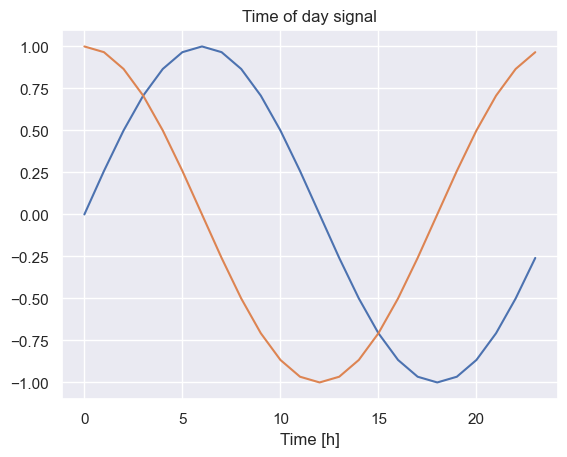

In [19]:
plt.plot(np.array(df['Day sin'])[:24])
plt.plot(np.array(df['Day cos'])[:24])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

With this dataset, it's actually beneficial to eliminate the earliest records. If we check the plots we can see that in the early years there were a lot of various data records suggesting either faulty equipment or some other problem.

In [20]:
df = df.query('datetime > 2014')

Drop features as we need to predict only one.

In [21]:
df = df.drop(['CO (mg/m3)', 'Ozone (ug/m3)', 'NOx (ug/m3)'], axis=1)

In [22]:
df.head()

,PM2.5 (ug/m3),Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2014-01-01 01:00:00,78.525000,0.258819,0.965926,0.006394,0.999980
2014-01-01 02:00:00,104.290000,0.500000,0.866025,0.007110,0.999975
2014-01-01 03:00:00,144.743333,0.707107,0.707107,0.007827,0.999969
2014-01-01 04:00:00,147.760000,0.866025,0.500000,0.008544,0.999963
2014-01-01 05:00:00,171.950000,0.965926,0.258819,0.009261,0.999957


In [23]:
df.shape

(81047, 5)

### Split the Data

In [24]:
val_split = 0.2
test_split = 0.1
n = len(df)

train_df = df[0:int(n*(1-val_split))]
val_df   = df[int(n*(1-(val_split+test_split))):int(n*(1-test_split))]
test_df  = df[int(n*(1-test_split)):]

n_features = df.shape[1]

### Normalization

In [25]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [26]:
def denormalize(data):
    return (data * train_std) + train_mean

## Time Series Forecasting

I will now perform time series forecasting using deep learning methods. I am going to compare those models with XGBoost, which proved to be the best model from the ensemble category.

### Dataset Preparation

In [27]:
class WindowGenerator():
    def __init__(self, input_width, label_width, predictors, train_df=train_df, val_df=val_df, test_df=test_df):
        '''
        Initializes a WindowGenerator object.

        Parameters
        ----------
            input_width (int): The input size of the hostory used for a prediction.
            label_width (int): How many steps into the future to predict.
            predictors (list: int): The features to be used as prediction targets.
            train_df (DataFrame): The training DataFrame.
            val_df (DataFrame): The validation DataFrame.
            test_df (DataFrame): The test DataFrame.
        '''
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.column_labels = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.predictors = predictors
        self.predictor_indices = [self.column_labels[predictor] for predictor in self.predictors]
        
        self.window_size = self.input_width + self.label_width
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.window_size)[self.input_slice]
        
        self.label_start = self.window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([f'Total window size: {self.window_size}',
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Predictor features: {self.predictors}'])

In [28]:
def split_window(self, data):
    np_df = np.array(data)
    inputs = []
    labels = []
    
    for i in range(len(np_df) - self.window_size):
        row = [observation for observation in np_df[i:i+self.input_width]]
        inputs.append(row)
        labels.append(np_df[i+self.input_width][self.predictor_indices])
    return np.array(inputs), np.array(labels)

WindowGenerator.split_window = split_window

In [29]:
def train(self):
    return self.split_window(self.train_df)

def val(self):
    return self.split_window(self.val_df)

def test(self):
    return self.split_window(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [30]:
single_step_window = WindowGenerator(input_width=24, label_width=1,
                                     predictors=['PM2.5 (ug/m3)'])
single_step_window 

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Predictor features: ['PM2.5 (ug/m3)']

In [31]:
X_train, y_train = single_step_window.train()
X_val, y_val = single_step_window.val()
X_test, y_test = single_step_window.test()

print('\n'.join([f'Train:\t\t {X_train.shape} | {y_train.shape}',
                 f'Validation:\t {X_val.shape} | {y_val.shape}',
                 f'Test:\t\t {X_test.shape}  | {y_test.shape}']))

Train:		 (64812, 24, 5) | (64812, 1)
Validation:	 (16185, 24, 5) | (16185, 1)
Test:		 (8080, 24, 5)  | (8080, 1)


In [32]:
n_steps = single_step_window.input_width
n_outputs = len(single_step_window.predictors)

### Deep Learning Methods

#### Long Short Term Memory (LSTM)

LSTMs are suitable for modeling univariate time series forecasting problems, which consist of a single series of observations. The models are trained on the past observations to predict the next value in the sequence. In this section I will explain and showcase several variations of the LSTM model for univariate time series forecasting.

##### Vanilla

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction

In [33]:
lstm_vanilla = tf.keras.Sequential([
    tf.keras.Input(shape=(n_steps, n_features)),
    LSTM(64),
    Dense(n_outputs, activation='linear')
])

##### Stacked

A stacked LSTM is an LSTM model that consists of multiple LSTM layers. In this architecture, an LSTM layer above provides a sequence output to the LSTM layer below, with one output per input time step. By stacking multiple LSTM layers, the model can capture even more complex temporal dependency patterns. Stacked LSTMs are often used in time series forecasting tasks to capture complex patterns in the data.

In [34]:
lstm_stacked = tf.keras.Sequential([
    tf.keras.Input(shape=(n_steps, n_features)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(n_outputs, activation='linear')
])

##### Bidirectional

A bidirectional LSTM is a type of LSTM model that allows information to flow both forward and backward in the sequence. In a standard LSTM, information flows only in one direction, from past to future. However, in a bidirectional LSTM, the input sequence is split into two parts: one processed in the forward direction and the other in the reverse direction.

The outputs from both directions are then combined, typically by concatenation, to form the final output sequence. This is achieved by duplicating the hidden layer of the LSTM and processing the input sequence in both directions. This enables the model to capture patterns that may depend on future as well as past observations.

In [35]:
lstm_bi = tf.keras.Sequential([
    tf.keras.Input(shape=(n_steps, n_features)),
    tf.keras.layers.Bidirectional(LSTM(64)),
    Dense(n_outputs, activation='linear')
])

##### Stacked Bidirectional

A stacked bidirectional LSTM is a type of LSTM model that combines the concepts of stacked LSTMs and bidirectional LSTMs. It consists of multiple LSTM layers, where each layer processes the input sequence in both the forward and backward directions. This allows the model to capture complex temporal dependencies by considering both past and future context.

In a stacked bidirectional LSTM, the output sequence from one LSTM layer is fed as input to the next LSTM layer, similar to a stacked LSTM. However, each LSTM layer in a stacked bidirectional LSTM is bidirectional, meaning it processes the input sequence in both directions. The outputs from all the LSTM layers are then combined to form the final output sequence.

In [36]:
lstm_stacked_bi = tf.keras.Sequential([
    tf.keras.Input(shape=(n_steps, n_features)),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(64)),
    Dense(n_outputs, activation='linear')
])

#### Training

In [37]:
models = {
    "vanilla":               lstm_vanilla,
    "stacked":               lstm_stacked,
    "bidirectional":         lstm_bi,
    "bidirectional_stacked": lstm_stacked_bi
}

In [38]:
def compile_and_fit(model, num_epochs, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                      patience = 2,
                                                      mode = 'min',
                                                      restore_best_weights = True,
                                                      start_from_epoch = 6)

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = MeanSquaredError(),
                  metrics = [MeanAbsoluteError()])

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=num_epochs,
                        callbacks = [early_stopping])

    return history

In [39]:
NUM_EPOCHS = 50
histories = {}

for model_arch, model in models.items():
    clear_output(wait=False)
    print('Training', model_arch, 'LSTM network...')
    histories[model_arch] = compile_and_fit(model, NUM_EPOCHS)

Training bidirectional_stacked LSTM network...
Epoch 1/50
2026/2026 [==============================] - 60s 26ms/step - loss: 0.0736 - mean_absolute_error: 0.1603 - val_loss: 0.0227 - val_mean_absolute_error: 0.1106
Epoch 2/50
2026/2026 [==============================] - 51s 25ms/step - loss: 0.0566 - mean_absolute_error: 0.1349 - val_loss: 0.0183 - val_mean_absolute_error: 0.0892
Epoch 3/50
2026/2026 [==============================] - 51s 25ms/step - loss: 0.0544 - mean_absolute_error: 0.1309 - val_loss: 0.0193 - val_mean_absolute_error: 0.0913
Epoch 4/50
2026/2026 [==============================] - 51s 25ms/step - loss: 0.0525 - mean_absolute_error: 0.1281 - val_loss: 0.0162 - val_mean_absolute_error: 0.0820
Epoch 5/50
2026/2026 [==============================] - 51s 25ms/step - loss: 0.0513 - mean_absolute_error: 0.1260 - val_loss: 0.0143 - val_mean_absolute_error: 0.0772
Epoch 6/50
2026/2026 [==============================] - 51s 25ms/step - loss: 0.0504 - mean_absolute_error: 0.124

#### Performance

In [40]:
metric_name = 'mean_absolute_error'

def plot_errors(histories):        
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
    for model_arch, history in histories.items():
        axes[0].plot(history.history[metric_name], label=model_arch)
        axes[1].plot(history.history[f'val_{metric_name}'], label=model_arch)
        
    axes[0].set_title(metric_name)
    axes[1].set_title(f'Validation {metric_name}')
    
    axes[0].legend()
    axes[1].legend()

    plt.show()

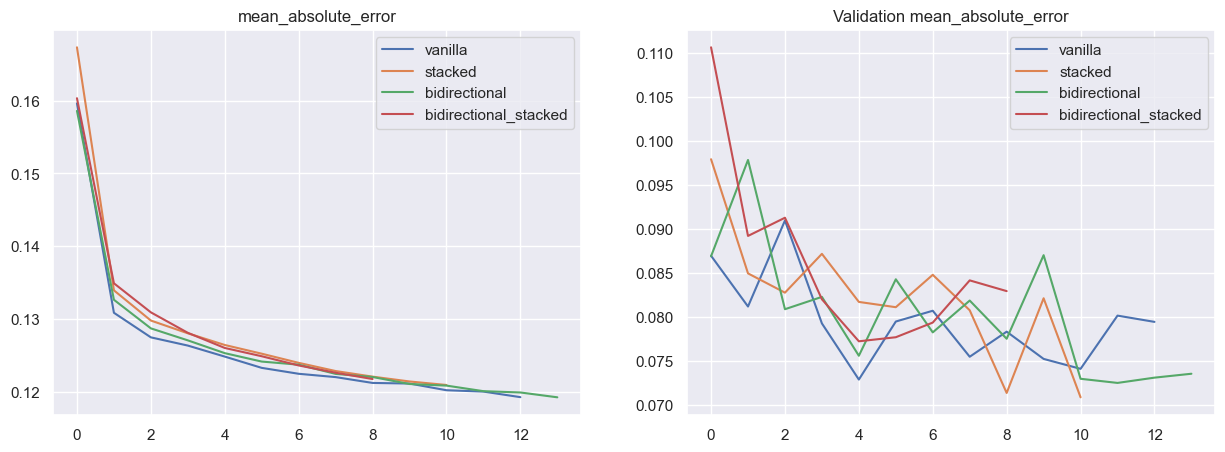

In [41]:
plot_errors(histories)

In [42]:
best_scores = []

for model_arch, history in histories.items():
    best_scores.append([model_arch,
                        min(history.history['val_loss']),
                        min(history.history[f'val_{metric_name}'])])

In [43]:
best_scores = pd.DataFrame(best_scores, columns =['Architecture', 'MSE', 'MAE'])
best_scores = best_scores.set_index('Architecture')
best_scores.sort_values(by=['MAE'])

,MSE,MAE
Architecture,,
stacked,0.011891,0.070877
bidirectional,0.012489,0.072511
vanilla,0.012977,0.072894
bidirectional_stacked,0.014241,0.077239


In [44]:
val_performance = {}
performance = {}

for model_arch, model in models.items():
    val_performance[model_arch] = model.evaluate(X_val, y_val)
    performance[model_arch] = model.evaluate(X_test, y_test, verbose=0)

506/506 [==============================] - 4s 9ms/step - loss: 0.0145 - mean_absolute_error: 0.0794


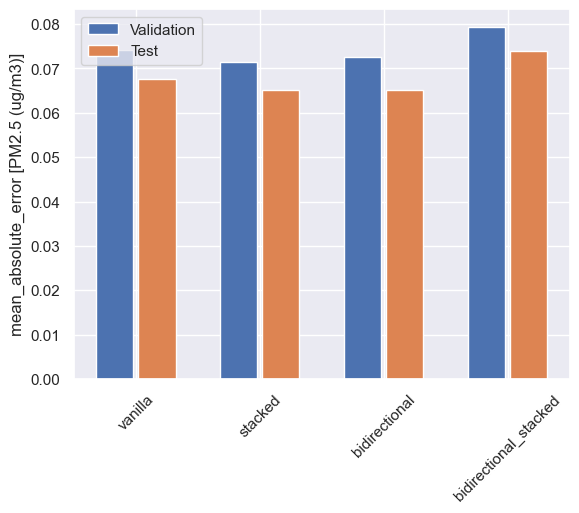

In [45]:
x = np.arange(len(performance))
width = 0.3
val_mae = [val_performance[model][1] for model in list(models.keys())]
test_mae = [performance[model][1] for model in list(models.keys())]

plt.ylabel(f'{metric_name} [PM2.5 (ug/m3)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=models.keys(), rotation=45)
_ = plt.legend()

253/253 [==============================] - 4s 9ms/step


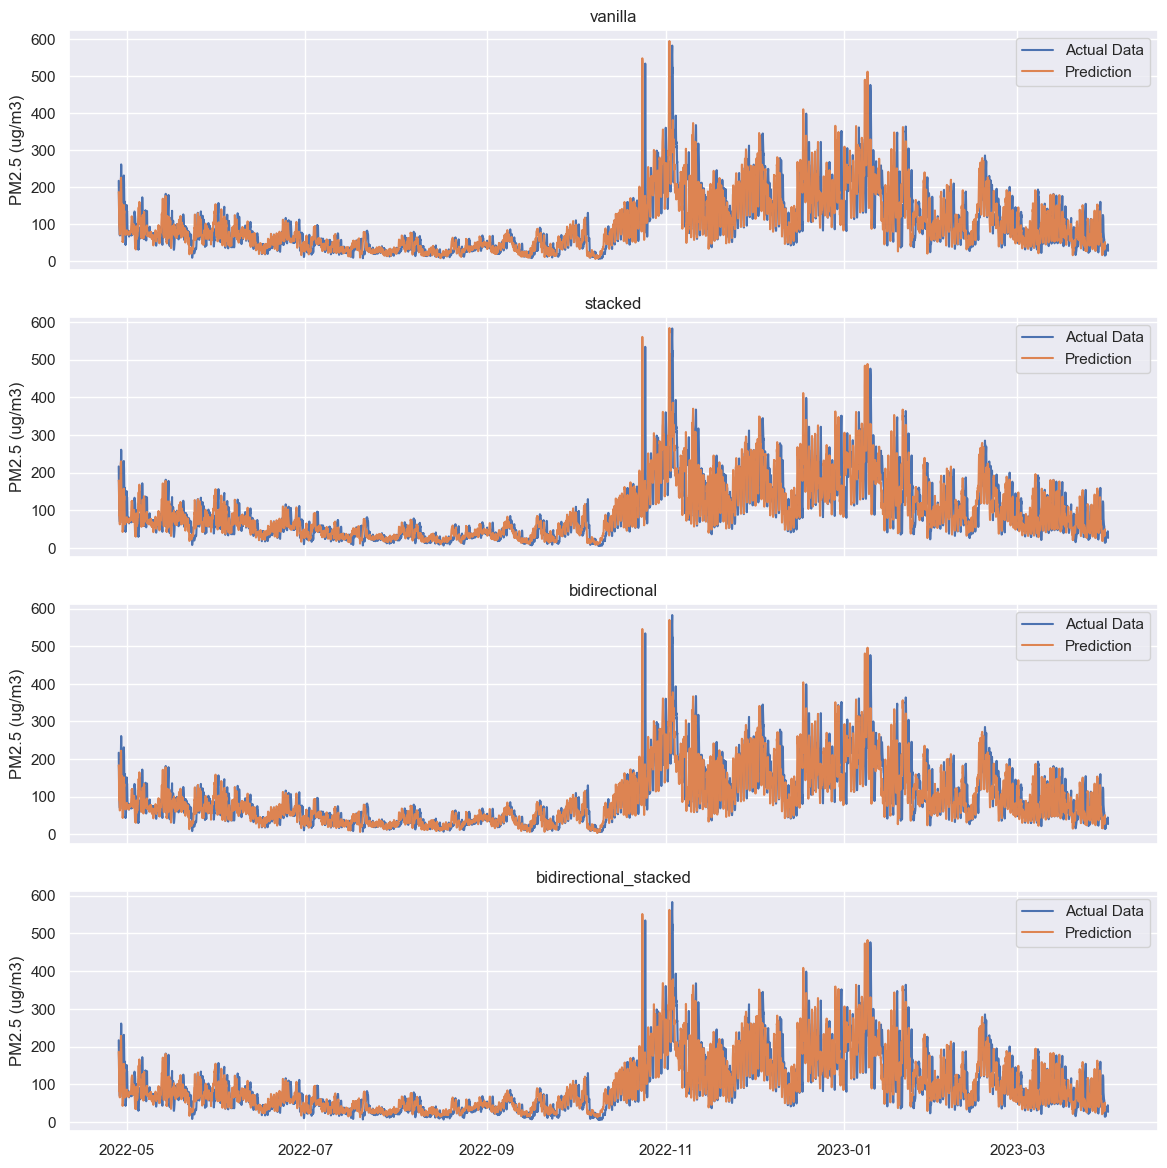

In [46]:
fig, axes = plt.subplots(len(models), 1, figsize=(12, 3*len(models)), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(models.items()):
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions, index=test_df.index[:-single_step_window.input_width-1], columns=single_step_window.predictors)

    predictions_denormalized = denormalize(predictions)
    test_df_denormalized = denormalize(test_df)
    
    sns.lineplot(data=test_df_denormalized, x=test_df_denormalized.index, y=single_step_window.predictors[0], label="Actual Data", ax=axes[index])
    sns.lineplot(data=predictions_denormalized, x=predictions_denormalized.index, y=single_step_window.predictors[0], label="Prediction", ax=axes[index])
    axes[index].set_title(model_name)
    axes[index].set(xlabel=None)
    
plt.show()